In [1]:
using LinearAlgebra: dot
using Plots, LaTeXStrings
using ReducedBasisMethods
using Particles
using Particles.BumpOnTail
using Random

In [2]:
const spline_degree = 3

nₚ₁ = 10
nₚ₂ = 1
nₚ₃ = 1
nₚ₄ = 1
nₚ₅ = 1

IP = IntegratorParameters(1e-1, 250, 251, 16, Int(5e3), nₚ₁*nₚ₂*nₚ₃*nₚ₄*nₚ₅)
#                           dt   nₜ   nₛ          nₚ            nₕ    Nₚ

κₘᵢₙ  = 0.1;  κₘₐₓ  = 0.5;
εₘᵢₙ  = 0.03; εₘₐₓ  = 0.03;
aₘᵢₙ  = 0.1;  aₘₐₓ  = 0.1;
v₀ₘᵢₙ = 4.5;  v₀ₘₐₓ = 4.5;
σₘᵢₙ  = 0.5;  σₘₐₓ  = 0.5;

κₛₐₘₚ = 0.3; εₛₐₘₚ = 0.03; aₛₐₘₚ = 0.1; v₀ₛₐₘₚ= 4.5; σₛₐₘₚ = 0.5

#ζₘₐₓ = (κₛₐₘₚ/κₘᵢₙ); ζₘᵢₙ = (κₛₐₘₚ/κₘₐₓ)
#         ζ = λ*ζₘᵢₙ + (1-λ)*ζₘₐₓ
#         μ[i,1] = κₛₐₘₚ/ζ

μ = zeros(IP.nparam, 5)
for i in axes(μ,1)
    μ[i,:] = [κₘᵢₙ, εₛₐₘₚ, aₛₐₘₚ, v₀ₛₐₘₚ, σₛₐₘₚ]
end

for i in axes(μ,1)
    μ[i,1] += (κₘₐₓ - κₘᵢₙ)*(i-1)/(IP.nparam-1)
end

# for i in 1:IP.nₚ
#     μ[i,:] = [κₘᵢₙ + rand(1)[1] * (κₘₐₓ - κₘᵢₙ), 
#             εₘᵢₙ + rand(1)[1] * (εₘₐₓ - εₘᵢₙ), 
#             aₘᵢₙ + rand(1)[1] * (aₘₐₓ - aₘᵢₙ),
#             v₀ₘᵢₙ + rand(1)[1] * (v₀ₘₐₓ - v₀ₘᵢₙ),
#             σₘᵢₙ + rand(1)[1] * (σₘₐₓ - σₘᵢₙ)]
# end

# wave number κ, amplitude ε, tail percentage, tail mean v₀, tail sd σ
μₛₐₘₚ = [κₛₐₘₚ, εₛₐₘₚ, aₛₐₘₚ, v₀ₛₐₘₚ, σₛₐₘₚ]

params = (κ = 0.3, ε = 0.03, a = 0.1, v₀= 4.5, σ = 0.5, χ = 1.0)

μ

10×5 Matrix{Float64}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

In [3]:
χ = μ[:,1] ./ params.κ

10-element Vector{Float64}:
 0.33333333333333337
 0.48148148148148157
 0.6296296296296297
 0.7777777777777779
 0.925925925925926
 1.074074074074074
 1.2222222222222223
 1.3703703703703705
 1.5185185185185188
 1.6666666666666667

In [4]:
poisson = PoissonSolverPBSplines(spline_degree, IP.nₕ, 2π/params.κ);

In [5]:
Random.seed!(1234)

MersenneTwister(1234)

In [6]:
# Reference draw
P₀ = BumpOnTail.draw_accept_reject(IP.nₚ, params);

In [7]:
@time IC = IntegratorCache(IP);

  0.309289 seconds (32.93 k allocations: 289.436 MiB, 21.20% gc time, 24.79% compilation time)


In [8]:
@time Result = ReducedBasisMethods.integrate_vp(P₀, μ, params, poisson, IP, IC; save=true, given_phi=false);

parameter nb. 1


parameter nb. 2


parameter nb. 3


parameter nb. 4


parameter nb. 5


parameter nb. 6


parameter nb. 7


parameter nb. 8


parameter nb. 9


parameter nb. 10


 18.117614 seconds (2.95 M allocations: 166.251 MiB, 2.36% gc time, 15.51% compilation time)


In [17]:
h5save("../runs/BoT_Np5e4_k_010_050_np_10_T25.h5", IP, poisson, params, μ, Result);

In [10]:
W = zero(Result.Φ[1,:]);

for i in eachindex(W)
    W[i] = 0.5 * dot(Result.Φ[:,i], poisson.M, Result.Φ[:,i])
end

W = reshape(W, (IP.nₛ,IP.nparam));

for p in axes(W,2)
    W[:,p] .*= χ[p]^2
end

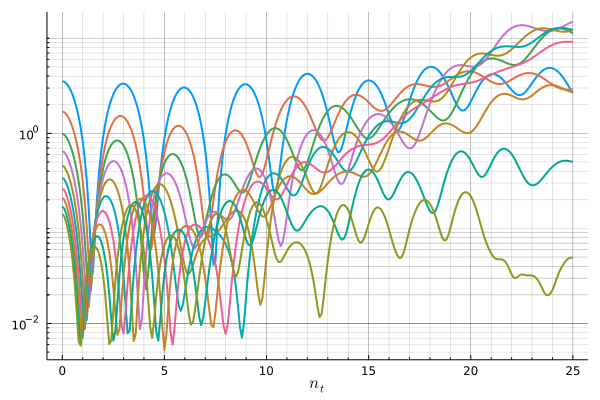

In [11]:
plot(IP.t, W[:,:], linewidth = 2, xlabel = L"$n_t$", yscale = :log10, legend = :none,
     grid = true, gridalpha = 0.5, minorgrid = true, minorgridalpha = 0.2)

IC = 0
Result = 0
GC.gc()

In [12]:
α, β = get_regression_αβ(IP.t, W, 2)
β

10-element Vector{Float64}:
 0.025884111936419412
 0.10566486997600029
 0.17494058574215907
 0.1783761457419606
 0.15773125237389385
 0.15988303506400153
 0.13413507370181396
 0.1033127525559727
 0.07144614351467751
 0.03791111585685096

In [13]:
Wₗᵢₙ = zero(W)
for i in axes(Wₗᵢₙ,2)
    Wₗᵢₙ[:,i] .= exp.(α[i] .+ β[i] .* IP.t)
end

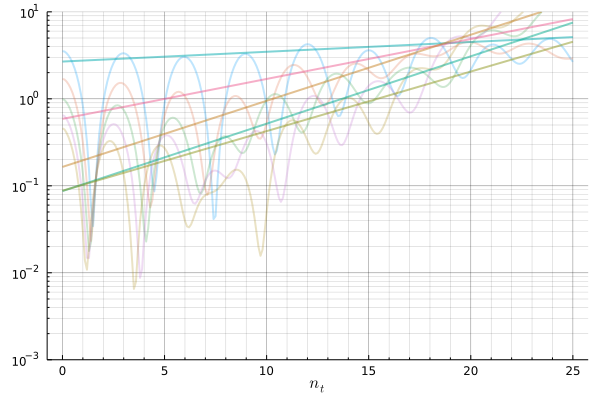

In [14]:
plot(xlabel = L"$n_t$", yscale = :log10, ylims = (1E-3,1E1), legend = :none,
     grid = true, gridalpha = 0.5, minorgrid = true, minorgridalpha = 0.2)
plot!(IP.t, W[:,1:5], linewidth = 2, alpha = 0.25)
plot!(IP.t, Wₗᵢₙ[:,1:5], linewidth = 2, alpha = 0.5)

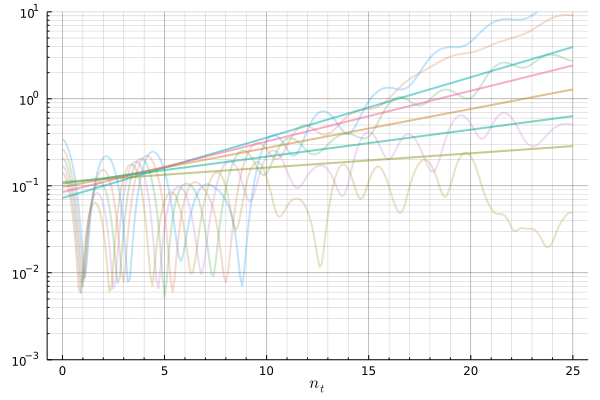

In [15]:
plot(xlabel = L"$n_t$", yscale = :log10, ylims = (1E-3,1E1), legend = :none,
     grid = true, gridalpha = 0.5, minorgrid = true, minorgridalpha = 0.2)
plot!(IP.t, W[:,6:10], linewidth = 2, alpha = 0.25)
plot!(IP.t, Wₗᵢₙ[:,6:10], linewidth = 2, alpha = 0.5)